In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
!ls ../data/

enregistrement_AM_2017-10-23_100057.asc
enregistrement_AM_2017-10-23_100057.edf
enregistrement_AM_2017-10-23_100057.pkl
enregistrement_BMC_2017-09-26_095637.asc
enregistrement_BMC_2017-09-26_095637.EDF
enregistrement_BMC_2017-09-26_095637.pkl
enregistrement_CS_2017-10-03_134421.asc
enregistrement_CS_2017-10-03_134421.edf
enregistrement_CS_2017-10-03_134421.pkl
enregistrement_DC_2017-09-27_161040.asc
enregistrement_DC_2017-09-27_161040.edf
enregistrement_DC_2017-09-27_161040.pkl
enregistrement_FM_2017-10-03_143803.asc
enregistrement_FM_2017-10-03_143803.EDF
enregistrement_FM_2017-10-03_143803.pkl
enregistrement_IP_2017-09-28_115250.asc
enregistrement_IP_2017-09-28_115250.edf
enregistrement_IP_2017-09-28_115250.pkl
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
enregistrement_OP_2017-10-26_121823.asc
enregistrement_OP_2017-10-26_121823.edf
enregistrement_OP_2017-10-26_1218

In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
def vitesse (x, tau=0.013, xT=0.01, t_T=0.2, latence=1200., bino=1) :
    '''
    tau -- constante oeuil (0.013)
    xT -- position en deg de la cible (1)
    t_T -- tps du mvt - s (0.1)
    start -- tps où commence le mvt
    bino -- binomial
    '''    
    if bino == 0:
        xT =xT*(-1)
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!
    latence = latence/1000 # en seconde
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N

    vitesse = []
    for t in range(len(time)):
        if (bino*2-1)*Umax*tau*(1-np.exp(-1/tau*(time[t]-latence))) < 0 :
            vitesse.append(0)
        else :
            vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-latence))))
    return vitesse

[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 76
    # data points      = 1893
    # variables        = 2
    chi-square         = 70.783
    reduced chi-square = 0.037
    Akaike info crit   = -6216.977
    Bayesian info crit = -6205.886
[[Variables]]
    tau:       0.013 (fixed)
    xT:        0.04233919 +/- 0.000663 (1.57%) (init= 0.05)
    t_T:       0.1 (fixed)
    latence:   1293.99842 +/- 1.998379 (0.15%) (init= 1157)
    bino:      1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(xT, latence)               =  0.110 



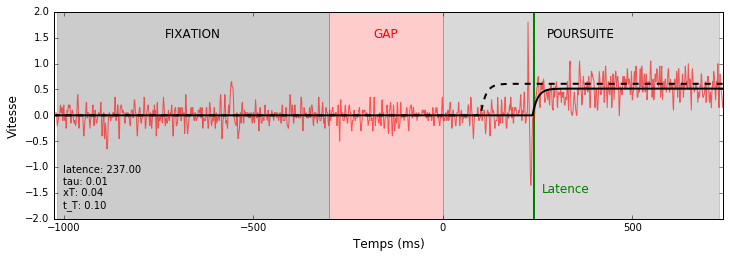

In [7]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
block = 0    
trial = 1

trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

trackertime_0 = data[trial_data]['trackertime'][0]


gradient_x = np.gradient(data_x)


# SUPPRESSION DES SACCADES
new_gradient_x=[]
new_time=[]

t=0
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_gradient_x.append(gradient_x[x_data])
        new_time.append(t)
        t = t+1
    saccade = None
    
StimulusOn_0 = StimulusOn
StimulusOf_0 = StimulusOf
TargetOn_0 = TargetOn
TargetOff_0 = TargetOff

for s in range(len(saccades)) :
    if StimulusOn_0 > (saccades[s][1]) :
        StimulusOn = StimulusOn - (saccades[s][2]+5)
    if StimulusOf_0 > (saccades[s][1]) :
        StimulusOf = StimulusOf - (saccades[s][2]+5)
    if TargetOn_0 > (saccades[s][1]) :
        TargetOn = TargetOn - (saccades[s][2]+5)
    if TargetOff_0 > (saccades[s][1]) :
        TargetOff = TargetOff - (saccades[s][2]+5)

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start

# FIT
model = Model(vitesse)

bino=p[trial, block, 0]
params = Parameters()
params.add('tau', value=0.013, min=0.013, max=0.02, vary=False) #min=0.001
params.add('xT', value=0.05, min=0.004, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.05, max=0.2, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_x))#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)
debut  = TargetOn - trackertime_0 # TargetOn - temps_0

axs.axis([StimulusOn_s-10, TargetOff_s+10, -2, 2])
axs.plot(np.asarray(new_time)-debut, new_gradient_x, color='r', alpha=0.6)
axs.plot(np.asarray(new_time)-debut, result.init_fit, 'k--', linewidth=2)
axs.plot(np.asarray(new_time)-debut, result.best_fit, color='k', linewidth=2)

axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)



latence = result.values['latence']
tau = result.values['tau']
xT = result.values['xT']
t_T = result.values['t_T']



axs.bar(latence-debut, 4, bottom=-2, color='g', width=6, linewidth=0)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 1.5, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 1.5, "GAP", color='r', fontsize=12, horizontalalignment='center')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 1.5, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
axs.text(latence-debut+25, -1.5, "Latence", color='g', fontsize=12)#,  weight='bold')
#axs.text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=10)
axs.text(StimulusOn_s+15, -1.8, "latence: %4.2f \ntau: %0.2f \nxT: %0.2f \nt_T: %0.2f"%(latence-debut, tau, xT, t_T), color='k', fontsize=10)

#axs.text(500, 0.65, "Fonction", color='k', fontsize=16, weight='bold')
#axs.text(250, 0.34, "Fit", color='k', fontsize=16, weight='bold')

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)

print(result.fit_report())